In [1]:
# ==================== CELL 1: Basic setup ====================
import os
import random
from pathlib import Path

import torch

print("Torch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# For reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Torch version: 2.9.0+cu126
Using device: cuda


In [2]:
# ==================== CELL 2: Install dependencies ====================
!pip install -q timm torchmetrics huggingface_hub kaggle gdown

print("✓ Dependencies installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 17.5 MB/s eta 0:00:00
✓ Dependencies installed


In [4]:
# ==================== CELL 3: Authenticate + Download RETFound weights ====================
from huggingface_hub import notebook_login, hf_hub_download

print("🔐 Logging into HuggingFace...")
notebook_login()

print("\nDownloading RETFound model weights (CFP encoder)...")
ckpt_path = hf_hub_download(
    repo_id="YukunZhou/RETFound_mae_natureCFP",
    filename="RETFound_mae_natureCFP.pth",
    cache_dir="/root/.cache/huggingface"
)

print(f"✓ Model downloaded to: {ckpt_path}")

🔐 Logging into HuggingFace...


RETFound_mae_natureCFP.pth:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

✓ Model downloaded to: /root/.cache/huggingface/models--YukunZhou--RETFound_mae_natureCFP/snapshots/556830f78214f0e8da35af965292ac5a3180ac47/RETFound_mae_natureCFP.pth


In [5]:
# ==================== CELL 4: Configure Kaggle ====================
import json
from google.colab import files

print("Upload kaggle.json from your Kaggle account settings.")
uploaded = files.upload()

kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")
with open(kaggle_json_path, "w") as f:
    f.write(list(uploaded.values())[0].decode("utf-8"))

os.chmod(kaggle_json_path, 0o600)
print("✓ Kaggle credentials set up at ~/.kaggle/kaggle.json")

Upload kaggle.json from your Kaggle account settings.


Saving kaggle.json to kaggle.json
✓ Kaggle credentials set up at ~/.kaggle/kaggle.json


In [6]:
# ==================== CELL 5: Mount Google Drive for HRDC Dataset ====================
from google.colab import drive

print("Mounting Google Drive...")
drive.mount('/content/drive')
print("✓ Google Drive mounted at /content/drive")

Mounting Google Drive...
Mounted at /content/drive
✓ Google Drive mounted at /content/drive


In [7]:
# ==================== CELL 6: Download Datasets (HRDC Task 1 + Task 2 + Zoya) ====================
from pathlib import Path
import shutil
import os
import zipfile

print("="*70)
print("DOWNLOADING ALL DATASETS")
print("="*70)

BASE = Path("/content/hypertension_data")
BASE.mkdir(parents=True, exist_ok=True)

# 1) HRDC Tasks 1 & 2 from Kaggle (uploaded by harshwardhanfartale)
print("\n1️⃣ Downloading HRDC Tasks (1 & 2) from Kaggle...")
print("   Note: This dataset contains BOTH:")
print("   - Task 1: Hypertensive Classification (binary: HTN vs normal)")
print("   - Task 2: Hypertensive Retinopathy Classification (grades: 0,1,2,3)")

hrdc_kaggle_dir = BASE / "HRDC_KAGGLE"
hrdc_kaggle_dir.mkdir(parents=True, exist_ok=True)
!kaggle datasets download -d harshwardhanfartale/hypertension-and-hypertensive-retinopathy-dataset -p {hrdc_kaggle_dir} --unzip
print("  ✓ HRDC Tasks downloaded")

# 2) HTN_ZOYA77 from Kaggle
print("\n2️⃣ Downloading HTN_ZOYA77 from Kaggle...")
zoya_dir = BASE / "HTN_ZOYA77"
zoya_dir.mkdir(parents=True, exist_ok=True)
!kaggle datasets download -d zoya77/hypertensive-retinopathy-fundus-image-dataset -p {zoya_dir} --unzip
print("  ✓ HTN_ZOYA77 downloaded")

# Show what we got
print("\n" + "="*70)
print("📊 Dataset Status:")

# Check HRDC Kaggle
if hrdc_kaggle_dir.exists():
    csv_files = list(hrdc_kaggle_dir.rglob("*.csv"))
    image_files = (list(hrdc_kaggle_dir.rglob("*.jpg")) +
                   list(hrdc_kaggle_dir.rglob("*.jpeg")) +
                   list(hrdc_kaggle_dir.rglob("*.png")))

    print(f"\n✅ HRDC_KAGGLE: {len(image_files)} images, {len(csv_files)} CSV files")
    if csv_files:
        print("   CSV files found:")
        for csv in csv_files:
            print(f"     - {csv.name}")

# Check Zoya
if zoya_dir.exists():
    image_files = (list(zoya_dir.rglob("*.jpg")) +
                   list(zoya_dir.rglob("*.jpeg")) +
                   list(zoya_dir.rglob("*.png")))
    print(f"\n✅ HTN_ZOYA77: {len(image_files)} images")

print("="*70)

DOWNLOADING ALL DATASETS

1️⃣ Downloading HRDC Tasks (1 & 2) from Kaggle...
   Note: This dataset contains BOTH:
   - Task 1: Hypertensive Classification (binary: HTN vs normal)
   - Task 2: Hypertensive Retinopathy Classification (grades: 0,1,2,3)
Dataset URL: https://www.kaggle.com/datasets/harshwardhanfartale/hypertension-and-hypertensive-retinopathy-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 96% 984M/1.00G [00:11<00:01, 39.4MB/s]
100% 1.00G/1.00G [00:11<00:00, 95.4MB/s]
  ✓ HRDC Tasks downloaded

2️⃣ Downloading HTN_ZOYA77 from Kaggle...
Dataset URL: https://www.kaggle.com/datasets/zoya77/hypertensive-retinopathy-fundus-image-dataset
License(s): CC0-1.0
  0% 0.00/15.2M [00:00<?, ?B/s]
100% 15.2M/15.2M [00:00<00:00, 1.09GB/s]
  ✓ HTN_ZOYA77 downloaded

📊 Dataset Status:

✅ HRDC_KAGGLE: 1424 images, 2 CSV files
   CSV files found:
     - HRDC Hypertensive Classification Training Labels.csv
     - HRDC Hypertensive Retinopathy Classification Traini

In [8]:
# ==================== EXTRACT HRDC FROM YOUR DRIVE (YOU ALREADY HAVE IT!) ====================

import zipfile
import os
from pathlib import Path

print("🎉 GOOD NEWS: You already have the HRDC dataset in your Drive!")
print("   File: '2-Hypertensive Retinopathy Classification.zip'")
print("\nExtracting it now...\n")

# Source zip file in your Drive
zip_file_path = "/content/drive/MyDrive/2-Hypertensive Retinopathy Classification.zip"

# Destination folder
hrdc_dir = "/content/hypertension_data/HRDC_TASK2"
os.makedirs(hrdc_dir, exist_ok=True)

try:
    # Check if zip file exists
    if os.path.exists(zip_file_path):
        print(f"✅ Found: {zip_file_path}")
        file_size = os.path.getsize(zip_file_path) / (1024 * 1024)  # Convert to MB
        print(f"   Size: {file_size:.1f} MB")

        print(f"\n📦 Extracting to: {hrdc_dir}")
        print("   (This may take 2-5 minutes...)\n")

        # Extract the zip file
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # Show progress
            members = zip_ref.namelist()
            total_files = len(members)
            print(f"   Total files to extract: {total_files}")

            # Extract all
            zip_ref.extractall(hrdc_dir)

        print(f"\n✅ Extraction complete!")

        # Verify extraction
        print("\n📊 Verifying extracted data:")

        # Count files and directories
        total_extracted_files = 0
        total_dirs = 0
        image_files = 0

        for root, dirs, files in os.walk(hrdc_dir):
            total_dirs += len(dirs)
            total_extracted_files += len(files)
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_files += 1

        print(f"   📁 Directories: {total_dirs}")
        print(f"   📄 Total files: {total_extracted_files}")
        print(f"   🖼️  Image files: {image_files}")

        # Show folder structure
        print(f"\n📂 Folder structure:")
        for root, dirs, files in os.walk(hrdc_dir):
            level = root.replace(hrdc_dir, '').count(os.sep)
            if level > 2:  # Don't go too deep
                continue
            indent = '  ' * level
            folder_name = os.path.basename(root) if os.path.basename(root) else 'HRDC_TASK2'
            print(f'{indent}📁 {folder_name}/')

            if level < 2:  # Show some files at top levels
                subindent = '  ' * (level + 1)
                shown_files = 0
                for file in files[:5]:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png', '.csv', '.txt')):
                        print(f'{subindent}📄 {file}')
                        shown_files += 1
                if len(files) > 5:
                    print(f'{subindent}... and {len(files) - 5} more files')

        if image_files > 0:
            print(f"\n🎉 SUCCESS! HRDC dataset is ready with {image_files} images!")
            print(f"   Location: {hrdc_dir}")
        else:
            print(f"\n⚠️ Warning: No image files found. Check the folder structure.")

    else:
        print(f"❌ Zip file not found at: {zip_file_path}")
        print("\nYour Drive contents:")
        for item in os.listdir("/content/drive/MyDrive"):
            print(f"   - {item}")

except Exception as e:
    print(f"❌ Error extracting zip file: {e}")
    import traceback
    traceback.print_exc()

    print("\n💡 Alternative: Try the gdown method in the next cell")

print("\n" + "="*70)
print("✅ You can now continue with the rest of the notebook!")
print("="*70)

🎉 GOOD NEWS: You already have the HRDC dataset in your Drive!
   File: '2-Hypertensive Retinopathy Classification.zip'

Extracting it now...

❌ Zip file not found at: /content/drive/MyDrive/2-Hypertensive Retinopathy Classification.zip

Your Drive contents:
   - Colab Notebooks

✅ You can now continue with the rest of the notebook!


In [9]:
# ==================== QUICK FIX: Remove HRDC CSV from Fartale Folder ====================

import os
from pathlib import Path

print("🧹 CLEANING UP: Removing misplaced HRDC files from Fartale folder...")
print("="*70)

BASE = Path("/content/hypertension_data")
fartale_dir = BASE / "HTN_FARTALE"

# Find and remove any HRDC-related CSV files in Fartale
if fartale_dir.exists():
    # Look for any file with "HRDC" in the name
    hrdc_files = list(fartale_dir.rglob("*HRDC*.csv")) + list(fartale_dir.rglob("*hrdc*.csv"))

    if hrdc_files:
        print(f"\n❌ Found {len(hrdc_files)} HRDC file(s) in Fartale folder:")
        for file in hrdc_files:
            print(f"   - {file.name}")
            print(f"     Location: {file}")
            os.remove(file)
            print(f"     ✓ Removed")

        print(f"\n✅ Cleaned up {len(hrdc_files)} misplaced file(s)")
    else:
        print("\n✓ No HRDC files found in Fartale folder (already clean)")

    # Show what CSV files remain in Fartale
    remaining_csvs = list(fartale_dir.rglob("*.csv"))
    if remaining_csvs:
        print(f"\n📄 Remaining CSV files in Fartale:")
        for csv in remaining_csvs:
            print(f"   - {csv.name}")
    else:
        print(f"\n📄 No CSV files in Fartale (will use folder structure)")
else:
    print("⚠️ Fartale folder not found")

print("\n" + "="*70)
print("✅ Cleanup complete! You can now re-run Cell 9")
print("="*70)

🧹 CLEANING UP: Removing misplaced HRDC files from Fartale folder...
⚠️ Fartale folder not found

✅ Cleanup complete! You can now re-run Cell 9


In [10]:
# ==================== CELL 7: Imports ====================
import pandas as pd
from PIL import Image
import numpy as np

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

import timm
from tqdm import tqdm

from torchmetrics.classification import (
    BinaryAccuracy,
    BinaryAUROC,
    BinaryPrecision,
    BinaryRecall,
    BinaryF1Score,
    BinaryAveragePrecision,
)

print("✓ All modules imported")

✓ All modules imported


In [11]:
# ==================== CELL 8: Define transforms (STRONGER augmentation) ====================
print("="*70)
print("DEFINING IMAGE TRANSFORMS (Enhanced for better generalization)")
print("="*70)

train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),

    # ADDED AND MODIFIED FOR STRONGER AUGMENTATION
    transforms.RandomRotation(20),  # Retinal images are rotation-invariant
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.2,
        hue=0.05
    ),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=5
    ),
    transforms.RandomGrayscale(p=0.1), # Added RandomGrayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.15)), # Increased p from 0.25 to 0.5
])
val_transform = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

print("✓ Training: Stronger augmentation with vertical flip, translation, random erasing, random grayscale")
print("✓ Val/Test: Standard Resize(256) + CenterCrop(224) + Normalize")
print("="*70)

DEFINING IMAGE TRANSFORMS (Enhanced for better generalization)
✓ Training: Stronger augmentation with vertical flip, translation, random erasing, random grayscale
✓ Val/Test: Standard Resize(256) + CenterCrop(224) + Normalize


In [12]:
# ==================== CELL 9: Load All 3 Datasets (HRDC Task 1 + Task 2 + Zoya) ====================
print("="*70)
print("BUILDING COMBINED IMAGE LIST FROM ALL 3 DATASETS")
print("="*70)

all_image_paths = []
all_labels = []  # 0 = normal, 1 = hypertensive

def find_images(directory, extensions=None):
    """Recursively find all images in a directory"""
    if extensions is None:
        extensions = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']

    images = []
    for ext in extensions:
        images.extend(list(Path(directory).rglob(f"*{ext}")))
    return images

# ---------- 1) HRDC TASK 1: Hypertensive Classification ----------
print("\n1️⃣ Processing HRDC Task 1 (Binary Classification)...")
hrdc_kaggle_base = BASE / "HRDC_KAGGLE"
task1_start = len(all_image_paths)

try:
    # Look for Task 1 CSV
    task1_csv = None
    for csv_file in hrdc_kaggle_base.rglob("*.csv"):
        if "hypertensive classification" in csv_file.name.lower() and "retinopathy" not in csv_file.name.lower():
            task1_csv = csv_file
            break

    if task1_csv:
        print(f"  Found CSV: {task1_csv.name}")
        df = pd.read_csv(task1_csv)
        print(f"  CSV has {len(df)} rows")
        print(f"  Columns: {list(df.columns)}")

        # Find images in Task 1 folder
        task1_folder = hrdc_kaggle_base / "1-Hypertensive Classification"
        if not task1_folder.exists():
            # Try alternative paths
            task1_folder = hrdc_kaggle_base / "1-Images"

        img_files = find_images(task1_folder) if task1_folder.exists() else find_images(hrdc_kaggle_base / "1-Hypertensive Classification")
        print(f"  Found {len(img_files)} images on disk")

        # Create lookup
        img_lookup = {}
        for img in img_files:
            img_lookup[img.name.lower()] = str(img)
            img_lookup[img.stem.lower()] = str(img)

        # Find label column
        label_col = None
        for col in ['Hypertensive', 'Hypertension', 'label', 'Label', 'class', 'target']:
            if col in df.columns:
                label_col = col
                print(f"  Using label column: '{col}'")
                print(f"  Unique values: {df[col].unique()}")
                break

        if not label_col:
            print(f"  ⚠️ Could not find label column!")
        else:
            matched = 0
            for _, row in df.iterrows():
                # Find image
                img_name = None
                for col in ['Image', 'image', 'filename', 'ID', 'id', 'file']:
                    if col in df.columns and pd.notna(row.get(col)):
                        img_name = str(row[col]).lower().strip()
                        break

                if not img_name:
                    continue

                # Match image
                img_path = None
                if img_name in img_lookup:
                    img_path = img_lookup[img_name]
                else:
                    for ext in ['.jpg', '.png', '.jpeg']:
                        if img_name + ext in img_lookup:
                            img_path = img_lookup[img_name + ext]
                            break

                if not img_path:
                    name_no_ext = os.path.splitext(img_name)[0]
                    if name_no_ext in img_lookup:
                        img_path = img_lookup[name_no_ext]

                if not img_path:
                    continue

                # Get label (Task 1 is binary: 0=normal, 1=HTN)
                label = 0
                val = row[label_col]
                try:
                    label = 1 if int(val) > 0 else 0
                except:
                    val_str = str(val).lower().strip()
                    if val_str in ['1', 'yes', 'true', 'hypertensive', 'htn', 'positive']:
                        label = 1
                    elif val_str in ['0', 'no', 'false', 'normal', 'negative']:
                        label = 0

                all_image_paths.append(img_path)
                all_labels.append(label)
                matched += 1

            print(f"  ✓ Matched {matched} images with labels")
    else:
        print("  ⚠️ No Task 1 CSV found")

    task1_count = len(all_image_paths) - task1_start
    if task1_count > 0:
        task1_htn = sum(all_labels[task1_start:])
        print(f"  ✓ HRDC Task 1: {task1_htn} HTN, {task1_count - task1_htn} normal ({task1_count} total)")
    else:
        print(f"  ⚠️ Task 1: 0 images")

except Exception as e:
    print(f"  ⚠️ Error: {e}")
    import traceback
    traceback.print_exc()

# ---------- 2) HRDC TASK 2: Hypertensive Retinopathy Classification ----------
print("\n2️⃣ Processing HRDC Task 2 (Graded Classification)...")
task2_start = len(all_image_paths)

try:
    # Look for Task 2 CSV
    task2_csv = None
    for csv_file in hrdc_kaggle_base.rglob("*.csv"):
        if "retinopathy classification" in csv_file.name.lower():
            task2_csv = csv_file
            break

    if task2_csv:
        print(f"  Found CSV: {task2_csv.name}")
        df = pd.read_csv(task2_csv)
        print(f"  CSV has {len(df)} rows")
        print(f"  Columns: {list(df.columns)}")

        # Find images in Task 2 folder
        task2_folder = hrdc_kaggle_base / "2-Hypertensive Retinopathy Classification"
        if not task2_folder.exists():
            task2_folder = hrdc_kaggle_base / "2-Images"

        img_files = find_images(task2_folder) if task2_folder.exists() else find_images(hrdc_kaggle_base)
        print(f"  Found {len(img_files)} images on disk")

        # Create lookup
        img_lookup = {}
        for img in img_files:
            img_lookup[img.name.lower()] = str(img)
            img_lookup[img.stem.lower()] = str(img)
            # Add numeric matching
            import re
            numbers = re.findall(r'\d+', img.stem)
            if numbers:
                for num in numbers:
                    img_lookup[num] = str(img)
                    img_lookup[num.lstrip('0') or '0'] = str(img)

        # Find label column
        label_col = None
        for col in ['Hypertensive Retinopathy', 'Hypertensive', 'label', 'Label', 'grade', 'class']:
            if col in df.columns:
                label_col = col
                print(f"  Using label column: '{col}'")
                print(f"  Unique values: {df[col].unique()}")
                break

        if not label_col:
            print(f"  ⚠️ Could not find label column!")
        else:
            matched = 0
            for idx, row in df.iterrows():
                # Find image
                img_name = None
                for col in ['Image', 'image', 'filename', 'ID', 'id', 'file']:
                    if col in df.columns and pd.notna(row.get(col)):
                        img_name = str(row[col]).lower().strip()
                        break

                if not img_name:
                    img_name = str(idx)

                # Match image (with multiple strategies)
                img_path = None
                if img_name in img_lookup:
                    img_path = img_lookup[img_name]
                else:
                    for ext in ['.jpg', '.png', '.jpeg']:
                        if img_name + ext in img_lookup:
                            img_path = img_lookup[img_name + ext]
                            break

                if not img_path:
                    name_no_ext = os.path.splitext(img_name)[0]
                    if name_no_ext in img_lookup:
                        img_path = img_lookup[name_no_ext]

                if not img_path:
                    import re
                    numbers = re.findall(r'\d+', img_name)
                    if numbers:
                        for num in numbers:
                            if num in img_lookup:
                                img_path = img_lookup[num]
                                break
                            num_stripped = num.lstrip('0') or '0'
                            if num_stripped in img_lookup:
                                img_path = img_lookup[num_stripped]
                                break

                if not img_path:
                    continue

                # Get label (Task 2: 0=normal, 1/2/3=HTN with different grades)
                # We binarize: 0=normal, >0=HTN
                label = 0
                val = row[label_col]
                try:
                    label = 1 if float(val) > 0 else 0
                except:
                    val_str = str(val).lower().strip()
                    if val_str in ['0', 'normal', 'no', 'negative']:
                        label = 0
                    elif val_str in ['1', '2', '3', 'mild', 'moderate', 'severe', 'hypertensive']:
                        label = 1

                all_image_paths.append(img_path)
                all_labels.append(label)
                matched += 1

            print(f"  ✓ Matched {matched} images with labels")
    else:
        print("  ⚠️ No Task 2 CSV found")

    task2_count = len(all_image_paths) - task2_start
    if task2_count > 0:
        task2_htn = sum(all_labels[task2_start:])
        print(f"  ✓ HRDC Task 2: {task2_htn} HTN, {task2_count - task2_htn} normal ({task2_count} total)")
    else:
        print(f"  ⚠️ Task 2: 0 images")

except Exception as e:
    print(f"  ⚠️ Error: {e}")
    import traceback
    traceback.print_exc()

# ---------- 3) HTN_ZOYA77 ----------
print("\n3️⃣ Processing HTN_ZOYA77...")
zoya_base = BASE / "HTN_ZOYA77"
zoya_start = len(all_image_paths)

try:
    all_dirs = set()
    for d in zoya_base.rglob("*"):
        if d.is_dir():
            all_dirs.add(d)

    processed_images = set()

    for folder in all_dirs:
        folder_name = folder.name.lower()
        folder_path_lower = str(folder).lower()

        is_normal = any(word in folder_name for word in ['normal', 'healthy', 'control', 'no_hr', 'no hr'])
        is_normal = is_normal or '/normal/' in folder_path_lower

        is_htn = any(word in folder_name for word in ['hypertensive', 'hypertension', 'htn', 'hr', 'disease'])
        is_htn = is_htn or '/hyper' in folder_path_lower or '/htn/' in folder_path_lower

        if not (is_normal or is_htn):
            continue

        label = 0 if is_normal else 1

        for img in folder.glob("*"):
            if img.suffix.lower() in ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']:
                img_str = str(img)
                if img_str not in processed_images:
                    all_image_paths.append(img_str)
                    all_labels.append(label)
                    processed_images.add(img_str)

    zoya_count = len(all_image_paths) - zoya_start
    zoya_htn = sum(all_labels[zoya_start:])
    print(f"  ✓ HTN_ZOYA77: {zoya_htn} HTN, {zoya_count - zoya_htn} normal ({zoya_count} total)")

except Exception as e:
    print(f"  ⚠️ Error: {e}")
    import traceback
    traceback.print_exc()

# ---------- Validation ----------
print("\n" + "="*70)
print("VALIDATING FILES...")
print("="*70)

valid_paths = []
valid_labels = []
removed = 0

for path, label in zip(all_image_paths, all_labels):
    if os.path.exists(path):
        valid_paths.append(path)
        valid_labels.append(label)
    else:
        removed += 1

all_image_paths = valid_paths
all_labels = valid_labels

if len(all_image_paths) == 0:
    raise ValueError("No images found! Please check dataset paths.")

print(f"\n✓ Final dataset: {len(all_image_paths)} images")
print(f"  - HTN: {sum(all_labels)} ({100*sum(all_labels)/len(all_labels):.1f}%)")
print(f"  - Normal: {len(all_labels) - sum(all_labels)} ({100*(len(all_labels)-sum(all_labels))/len(all_labels):.1f}%)")
print(f"  - Removed {removed} invalid paths")

if len(all_labels) > 0:
    htn_count = sum(all_labels)
    normal_count = len(all_labels) - htn_count
    if normal_count > 0:
        ratio = htn_count / normal_count
        print(f"  - Class ratio: {ratio:.2f}:1 (HTN:Normal)")

# Final check
if sum(all_labels) == 0 or sum(all_labels) == len(all_labels):
    print("\n❌ CRITICAL: All images same label!")
elif sum(all_labels) < 50 or (len(all_labels) - sum(all_labels)) < 50:
    print("\n⚠️ WARNING: Very few examples of one class.")
else:
    print("\n✅ Dataset looks good! All 3 datasets loaded successfully!")

print("="*70)

BUILDING COMBINED IMAGE LIST FROM ALL 3 DATASETS

1️⃣ Processing HRDC Task 1 (Binary Classification)...
  Found CSV: HRDC Hypertensive Classification Training Labels.csv
  CSV has 712 rows
  Columns: ['Image', 'Hypertensive']
  Found 712 images on disk
  Using label column: 'Hypertensive'
  Unique values: [0 1]
  ✓ Matched 712 images with labels
  ✓ HRDC Task 1: 356 HTN, 356 normal (712 total)

2️⃣ Processing HRDC Task 2 (Graded Classification)...
  Found CSV: HRDC Hypertensive Retinopathy Classification Training Labels.csv
  CSV has 712 rows
  Columns: ['Image', 'Hypertensive Retinopathy']
  Found 712 images on disk
  Using label column: 'Hypertensive Retinopathy'
  Unique values: [1 0]
  ✓ Matched 712 images with labels
  ✓ HRDC Task 2: 292 HTN, 420 normal (712 total)

3️⃣ Processing HTN_ZOYA77...
  ✓ HTN_ZOYA77: 94 HTN, 179 normal (273 total)

VALIDATING FILES...

✓ Final dataset: 1697 images
  - HTN: 742 (43.7%)
  - Normal: 955 (56.3%)
  - Removed 0 invalid paths
  - Class ratio: 0

In [13]:
# ==================== CELL 10: Dataset class and splits ====================
from sklearn.model_selection import train_test_split

class HypertensionFundusDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform is not None:
                image = self.transform(image)
            return image, torch.tensor(label, dtype=torch.float32)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a black image as fallback
            image = Image.new('RGB', (224, 224), color='black')
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label, dtype=torch.float32)

# 70/15/15 split
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.30, random_state=SEED, stratify=all_labels
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.50, random_state=SEED, stratify=temp_labels
)

print("Dataset splits:")
print(f"  Train: {len(train_paths)} ({sum(train_labels)} HTN, {len(train_labels)-sum(train_labels)} normal)")
print(f"  Val:   {len(val_paths)} ({sum(val_labels)} HTN, {len(val_labels)-sum(val_labels)} normal)")
print(f"  Test:  {len(test_paths)} ({sum(test_labels)} HTN, {len(test_labels)-sum(test_labels)} normal)")

train_dataset = HypertensionFundusDataset(train_paths, train_labels, transform=train_transforms) # Corrected typo: train_transform -> train_transforms
val_dataset = HypertensionFundusDataset(val_paths, val_labels, transform=val_transform)
test_dataset = HypertensionFundusDataset(test_paths, test_labels, transform=val_transform)

Dataset splits:
  Train: 1187 (519 HTN, 668 normal)
  Val:   255 (112 HTN, 143 normal)
  Test:  255 (111 HTN, 144 normal)


In [14]:
# ==================== CELL 11: DataLoaders ====================
BATCH_SIZE = 32 # Changed from 64 to 32

NUM_WORKERS = 4

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

print("✓ DataLoaders created")

✓ DataLoaders created


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [15]:
class RETFoundClassifier(nn.Module):
    def __init__(self, dropout=0.65):
        super().__init__()
        self.backbone = timm.create_model(
            "vit_large_patch16_224",
            pretrained=False,
            num_classes=0,
            global_pool="",
        )
        embed_dim = self.backbone.num_features  # 1024

        # SIMPLIFIED: 2-layer classifier
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 512),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        features = self.backbone.forward_features(x)
        if features.ndim == 3:
            features = features.mean(dim=1)
        return self.classifier(features)

print("="*70)
print("LOADING MODEL")
print("="*70)

model = RETFoundClassifier(dropout=0.65).to(device)

# Load RETFound weights
ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
state_dict = ckpt["model"] if "model" in ckpt else ckpt

backbone_state_dict = {}
for key, value in state_dict.items():
    if key.startswith("decoder"):
        continue
    new_key = key.replace("encoder.", "")
    backbone_state_dict[new_key] = value

msg = model.backbone.load_state_dict(backbone_state_dict, strict=False)
print("Backbone load message:", msg)

# Freeze all encoder blocks first
for p in model.backbone.parameters():
    p.requires_grad = False

# Unfreeze only last 4 blocks to reduce overfitting
######################
N_UNFROZEN_BLOCKS = 4
######################
if hasattr(model.backbone, "blocks"):
    num_blocks = len(model.backbone.blocks)
    start_idx = max(0, num_blocks - N_UNFROZEN_BLOCKS)
    print(f"Unfreezing last {N_UNFROZEN_BLOCKS} encoder blocks [{start_idx}..{num_blocks-1}]")
    for i in range(start_idx, num_blocks):
        for p in model.backbone.blocks[i].parameters():
            p.requires_grad = True

# Unfreeze final norm
if hasattr(model.backbone, "norm"):
    for p in model.backbone.norm.parameters():
        p.requires_grad = True

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")
print("="*70)

LOADING MODEL
Backbone load message: _IncompatibleKeys(missing_keys=[], unexpected_keys=['mask_token'])
Unfreezing last 4 encoder blocks [20..23]
Total params: 303,828,993
Trainable params: 50,914,305 (16.8%)


In [16]:
import torch.nn.functional as F

# Calculate class weights
pos = sum(all_labels)
neg = len(all_labels) - pos
pos_weight = torch.tensor([2.2], dtype=torch.float32).to(device)

print(f"Class balance: {pos} HTN, {neg} normal")
print(f"Pos weight: {pos_weight.item():.3f}")

# Simple BCE Loss (label smoothing optional - uncomment if you want it)
# BCE Loss with Label Smoothing (0.1) to reduce overfitting
LABEL_SMOOTHING = 0.1

class BCEWithLogitsLossLabelSmoothing(nn.Module):
    def __init__(self, pos_weight=None, label_smoothing=0.0):
           super().__init__()
           self.pos_weight = pos_weight
           self.label_smoothing = label_smoothing

    def forward(self, logits, targets):
           # Apply label smoothing
           if self.label_smoothing > 0:
               targets = targets * (1 - self.label_smoothing) + 0.5 * self.label_smoothing

           return F.binary_cross_entropy_with_logits(
               logits, targets, pos_weight=self.pos_weight
           )

criterion = BCEWithLogitsLossLabelSmoothing(pos_weight=pos_weight, label_smoothing=LABEL_SMOOTHING)

# FIXED HYPERPARAMETERS
LR = 1e-4  # CRITICAL FIX: Lowered initial LR
WEIGHT_DECAY = 1e-3 # INCREASED from 5e-4 to 1e-3 for stronger regularization

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY,
)

# OneCycleLR Scheduler
EPOCHS = 50

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=3e-4,  # Peak learning rate, lowered from 5e-4
    epochs=EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,  # 20% warmup
    anneal_strategy='cos',
    div_factor=25,  # start_lr = max_lr/25
    final_div_factor=1000  # min_lr = start_lr/1000
)

print(f"Optimizer: AdamW(lr={LR}, weight_decay={WEIGHT_DECAY})")
print(f"Scheduler: OneCycleLR(max_lr=3e-4, steps_per_epoch={len(train_loader)})")
print(f"Label smoothing: {LABEL_SMOOTHING}")

# Metrics
metrics = {
    "accuracy": BinaryAccuracy(threshold=0.5).to(device),
    "auroc": BinaryAUROC().to(device),
    "precision": BinaryPrecision(threshold=0.5).to(device),
    "recall": BinaryRecall(threshold=0.5).to(device),
    "f1": BinaryF1Score(threshold=0.5).to(device),
    "auprc": BinaryAveragePrecision().to(device),
}
print("✓ Loss, optimizer, scheduler, and metrics ready")

Class balance: 742 HTN, 955 normal
Pos weight: 2.200
Optimizer: AdamW(lr=0.0001, weight_decay=0.001)
Scheduler: OneCycleLR(max_lr=3e-4, steps_per_epoch=38)
Label smoothing: 0.1
✓ Loss, optimizer, scheduler, and metrics ready


In [17]:
# ==================== CELL 14: Training functions ====================
from torch.amp import autocast, GradScaler

scaler = GradScaler('cuda') # FIXED: Use new API to avoid deprecation warning

def train_one_epoch(model, loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"[Train] Epoch {epoch}")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Mixed precision training - FIXED: Use new autocast API
        with autocast('cuda'):
            logits = model(images)
            loss = criterion(logits.view(-1), labels)

        # Backprop with gradient scaling
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        # FIX: Apply gradient clipping to only trainable parameters of the optimizer
        torch.nn.utils.clip_grad_norm_(optimizer.param_groups[0]['params'], max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()

        # Step scheduler after each batch (OneCycleLR requirement)
        scheduler.step()

        running_loss += loss.item() * images.size(0)
        probs = torch.sigmoid(logits.view(-1))
        preds = (probs >= 0.5).float()
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix(loss=running_loss/total, acc=running_correct/total)

    return running_loss / total, running_correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, metrics, device, phase="Val"):
    model.eval()
    running_loss = 0.0

    for m in metrics.values():
        m.reset()

    for images, labels in tqdm(loader, desc=f"[{phase}]"):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits.view(-1), labels)
        running_loss += loss.item() * images.size(0)

        probs = torch.sigmoid(logits.view(-1))
        for m in metrics.values():
            m.update(probs, labels.int())

    results = {
        "loss": running_loss / len(loader.dataset),
        "accuracy": metrics["accuracy"].compute().item(),
        "auroc": metrics["auroc"].compute().item(),
        "precision": metrics["precision"].compute().item(),
        "recall": metrics["recall"].compute().item(),
        "f1": metrics["f1"].compute().item(),
        "auprc": metrics["auprc"].compute().item(),
    }
    return results

print("✓ Training functions defined")

✓ Training functions defined


[Val]: 100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Epoch 01: Train loss=1.0453, acc=0.4794 | Val loss=1.0168, acc=0.4392, AUROC=0.4604, F1=0.6104 | Gap=+0.040, LR=1.91e-05
  ✓ New best model (AUROC=0.4604, Val Loss=1.0168)


[Val]: 100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Epoch 02: Train loss=1.0199, acc=0.4465 | Val loss=1.0089, acc=0.4392, AUROC=0.5066, F1=0.6104 | Gap=+0.007, LR=3.96e-05
  ✓ New best model (AUROC=0.5066, Val Loss=1.0089)


[Val]: 100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Epoch 03: Train loss=1.0069, acc=0.4600 | Val loss=0.9934, acc=0.4627, AUROC=0.6140, F1=0.6205 | Gap=-0.003, LR=7.16e-05
  ✓ New best model (AUROC=0.6140, Val Loss=0.9934)


[Val]: 100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


Epoch 04: Train loss=0.9935, acc=0.4751 | Val loss=0.9611, acc=0.5098, AUROC=0.6977, F1=0.6377 | Gap=-0.035, LR=1.12e-04
  ✓ New best model (AUROC=0.6977, Val Loss=0.9611)


[Val]: 100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Epoch 05: Train loss=0.9596, acc=0.5687 | Val loss=0.9740, acc=0.6157, AUROC=0.7002, F1=0.6689 | Gap=-0.047, LR=1.57e-04
  ✓ New best model (AUROC=0.7002, Val Loss=0.9740)


[Val]: 100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Epoch 06: Train loss=0.9335, acc=0.5636 | Val loss=0.9170, acc=0.6667, AUROC=0.7357, F1=0.6909 | Gap=-0.103, LR=2.01e-04
  ✓ New best model (AUROC=0.7357, Val Loss=0.9170)


[Val]: 100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Epoch 07: Train loss=0.9220, acc=0.5779 | Val loss=0.9543, acc=0.5647, AUROC=0.7078, F1=0.6384 | Gap=+0.013, LR=2.41e-04


[Val]: 100%|██████████| 8/8 [00:11<00:00,  1.46s/it]


Epoch 08: Train loss=0.9350, acc=0.5872 | Val loss=0.8956, acc=0.5765, AUROC=0.7359, F1=0.6604 | Gap=+0.011, LR=2.73e-04
  ✓ New best model (AUROC=0.7359, Val Loss=0.8956)


[Val]: 100%|██████████| 8/8 [00:11<00:00,  1.41s/it]


Epoch 09: Train loss=0.9261, acc=0.5813 | Val loss=1.0879, acc=0.6118, AUROC=0.6814, F1=0.6452 | Gap=-0.030, LR=2.93e-04


[Val]: 100%|██████████| 8/8 [00:11<00:00,  1.47s/it]


Epoch 10: Train loss=0.9261, acc=0.6049 | Val loss=0.9152, acc=0.6745, AUROC=0.7519, F1=0.6719 | Gap=-0.070, LR=3.00e-04
  ✓ New best model (AUROC=0.7519, Val Loss=0.9152)


[Val]: 100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Epoch 11: Train loss=0.9013, acc=0.6142 | Val loss=0.9099, acc=0.7137, AUROC=0.7687, F1=0.6971 | Gap=-0.100, LR=3.00e-04
  ✓ New best model (AUROC=0.7687, Val Loss=0.9099)


[Val]: 100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Epoch 12: Train loss=0.8987, acc=0.6150 | Val loss=0.8664, acc=0.6941, AUROC=0.7799, F1=0.7023 | Gap=-0.079, LR=2.98e-04
  ✓ New best model (AUROC=0.7799, Val Loss=0.8664)


[Val]: 100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Epoch 13: Train loss=0.8786, acc=0.6142 | Val loss=0.8538, acc=0.6196, AUROC=0.7706, F1=0.6820 | Gap=-0.005, LR=2.96e-04


[Val]: 100%|██████████| 8/8 [00:11<00:00,  1.46s/it]


Epoch 14: Train loss=0.8887, acc=0.6175 | Val loss=0.9705, acc=0.6824, AUROC=0.7694, F1=0.6233 | Gap=-0.065, LR=2.93e-04


[Val]: 100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Epoch 15: Train loss=0.8696, acc=0.6259 | Val loss=0.9112, acc=0.6980, AUROC=0.7730, F1=0.6857 | Gap=-0.072, LR=2.88e-04


[Val]: 100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Epoch 16: Train loss=0.8553, acc=0.6226 | Val loss=0.8666, acc=0.6863, AUROC=0.7843, F1=0.6850 | Gap=-0.064, LR=2.84e-04
  ✓ New best model (AUROC=0.7843, Val Loss=0.8666)


[Val]: 100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


Epoch 17: Train loss=0.8429, acc=0.6605 | Val loss=0.8825, acc=0.6863, AUROC=0.7758, F1=0.6923 | Gap=-0.026, LR=2.78e-04


[Val]: 100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Epoch 18: Train loss=0.8418, acc=0.6580 | Val loss=1.0163, acc=0.7059, AUROC=0.7777, F1=0.6305 | Gap=-0.048, LR=2.71e-04


[Val]: 100%|██████████| 8/8 [00:12<00:00,  1.53s/it]


Epoch 19: Train loss=0.8235, acc=0.6748 | Val loss=0.8788, acc=0.6745, AUROC=0.7755, F1=0.6914 | Gap=+0.000, LR=2.64e-04


[Val]: 100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


Epoch 20: Train loss=0.8346, acc=0.6521 | Val loss=0.9250, acc=0.6706, AUROC=0.7609, F1=0.6557 | Gap=-0.019, LR=2.56e-04


[Val]: 100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Epoch 21: Train loss=0.8237, acc=0.6858 | Val loss=0.8846, acc=0.6706, AUROC=0.7703, F1=0.6818 | Gap=+0.015, LR=2.47e-04


[Val]: 100%|██████████| 8/8 [00:11<00:00,  1.50s/it]


Epoch 22: Train loss=0.8335, acc=0.6647 | Val loss=1.0608, acc=0.6824, AUROC=0.7737, F1=0.5970 | Gap=-0.018, LR=2.38e-04


[Val]: 100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Epoch 23: Train loss=0.8062, acc=0.6841 | Val loss=0.8699, acc=0.6980, AUROC=0.7957, F1=0.6751 | Gap=-0.014, LR=2.28e-04
  ✓ New best model (AUROC=0.7957, Val Loss=0.8699)


[Val]: 100%|██████████| 8/8 [00:12<00:00,  1.56s/it]


Epoch 24: Train loss=0.7970, acc=0.6984 | Val loss=0.9285, acc=0.6980, AUROC=0.7759, F1=0.6608 | Gap=+0.000, LR=2.18e-04


[Val]: 100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Epoch 25: Train loss=0.7783, acc=0.7102 | Val loss=0.8804, acc=0.6275, AUROC=0.7806, F1=0.6690 | Gap=+0.083, LR=2.07e-04


[Val]: 100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Epoch 26: Train loss=0.7999, acc=0.6807 | Val loss=0.8410, acc=0.7059, AUROC=0.8045, F1=0.7191 | Gap=-0.025, LR=1.96e-04
  ✓ New best model (AUROC=0.8045, Val Loss=0.8410)


[Val]: 100%|██████████| 8/8 [00:11<00:00,  1.41s/it]


Epoch 27: Train loss=0.7614, acc=0.7270 | Val loss=0.8482, acc=0.7176, AUROC=0.8020, F1=0.7165 | Gap=+0.009, LR=1.85e-04


[Val]: 100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Epoch 28: Train loss=0.7499, acc=0.7228 | Val loss=0.8608, acc=0.7098, AUROC=0.7993, F1=0.7016 | Gap=+0.013, LR=1.73e-04


[Val]: 100%|██████████| 8/8 [00:11<00:00,  1.44s/it]


Epoch 29: Train loss=0.7577, acc=0.7211 | Val loss=0.8974, acc=0.7059, AUROC=0.8039, F1=0.6781 | Gap=+0.015, LR=1.61e-04


[Val]: 100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


Epoch 30: Train loss=0.7544, acc=0.7169 | Val loss=0.9421, acc=0.7176, AUROC=0.7955, F1=0.6727 | Gap=-0.001, LR=1.50e-04


[Val]: 100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Epoch 31: Train loss=0.7360, acc=0.7540 | Val loss=1.0050, acc=0.7176, AUROC=0.7934, F1=0.6727 | Gap=+0.036, LR=1.38e-04


[Val]: 100%|██████████| 8/8 [00:12<00:00,  1.53s/it]


Epoch 32: Train loss=0.7287, acc=0.7464 | Val loss=1.0306, acc=0.7137, AUROC=0.7834, F1=0.6507 | Gap=+0.033, LR=1.26e-04


[Val]: 100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Epoch 33: Train loss=0.7079, acc=0.7591 | Val loss=0.9726, acc=0.7294, AUROC=0.7874, F1=0.6820 | Gap=+0.030, LR=1.15e-04


[Val]: 100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


Epoch 34: Train loss=0.7102, acc=0.7439 | Val loss=1.1330, acc=0.6863, AUROC=0.7892, F1=0.6000 | Gap=+0.058, LR=1.03e-04


[Val]: 100%|██████████| 8/8 [00:11<00:00,  1.46s/it]


Epoch 35: Train loss=0.7229, acc=0.7599 | Val loss=0.9758, acc=0.7255, AUROC=0.7865, F1=0.6818 | Gap=+0.034, LR=9.23e-05


[Val]: 100%|██████████| 8/8 [00:12<00:00,  1.54s/it]


Epoch 36: Train loss=0.7006, acc=0.7700 | Val loss=0.9573, acc=0.7294, AUROC=0.7938, F1=0.6933 | Gap=+0.041, LR=8.16e-05

⚠️ Early stopping at epoch 36 (no improvement for 10 epochs)

Training complete! Best AUROC: 0.8045


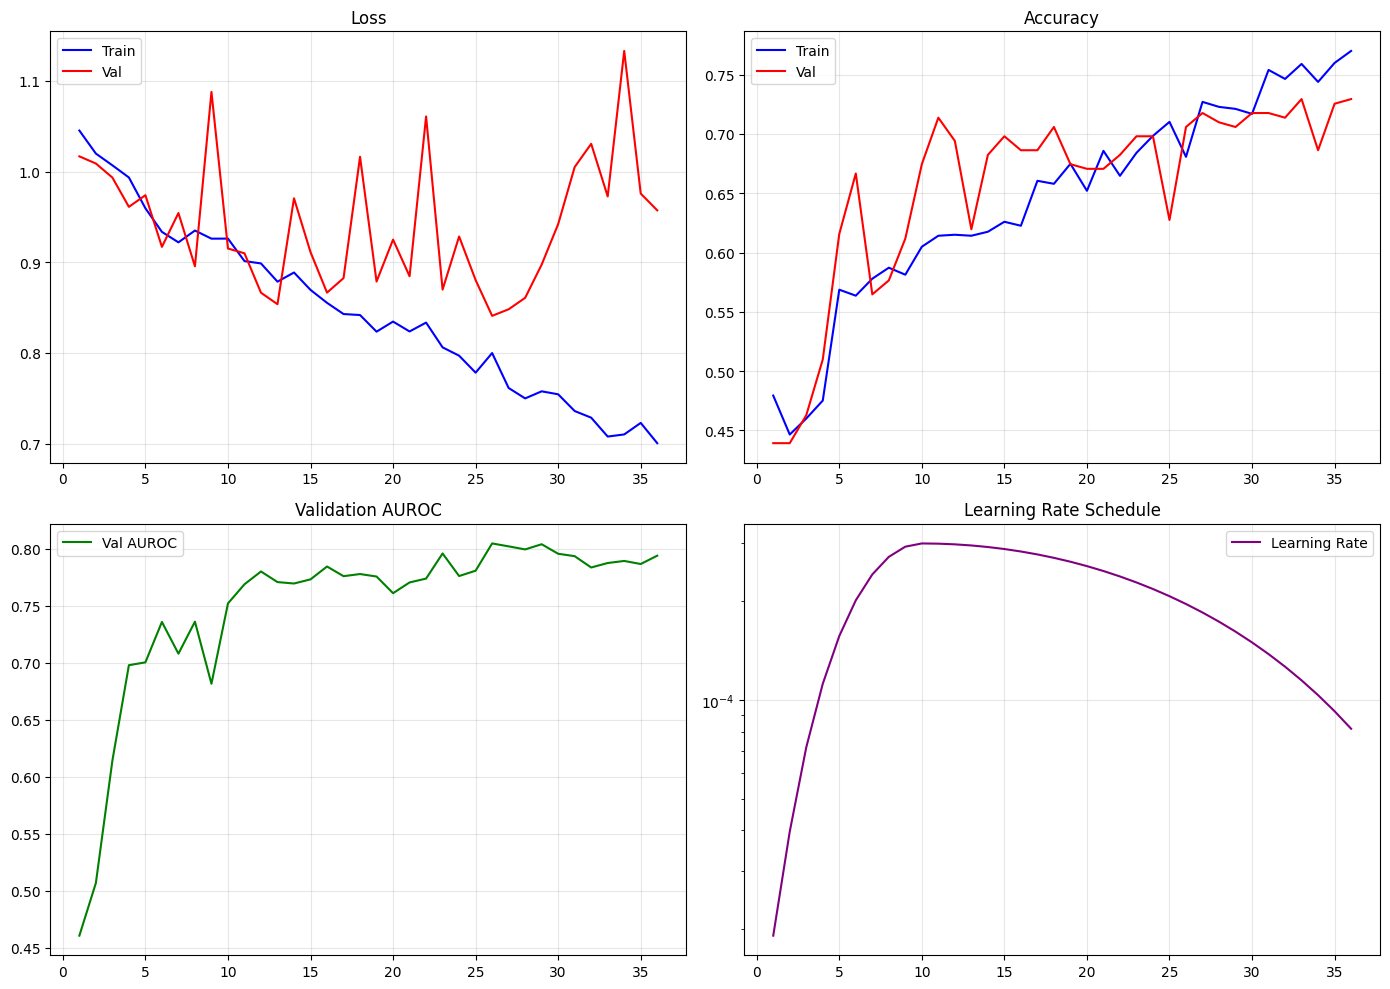

✓ Saved training curves


In [18]:
# ==================== CELL 15: Training loop with plotting ====================
import matplotlib.pyplot as plt

best_val_auroc = 0.0
best_val_loss = float('inf')
best_state = None
PATIENCE = 10 # REDUCED from 15 to 10 for earlier stopping
patience_counter = 0

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'val_auroc': [], 'val_f1': [],
    'lr': [], 'epoch': []
}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_stats = evaluate(model, val_loader, criterion, metrics, device, "Val")

    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    # Store metrics
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_stats['loss'])
    history['val_acc'].append(val_stats['accuracy'])
    history['val_auroc'].append(val_stats['auroc'])
    history['val_f1'].append(val_stats['f1'])
    history['lr'].append(current_lr)
    history['epoch'].append(epoch)

    acc_gap = train_acc - val_stats['accuracy']

    print(f"Epoch {epoch:02d}: "
          f"Train loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"Val loss={val_stats['loss']:.4f}, acc={val_stats['accuracy']:.4f}, "
          f"AUROC={val_stats['auroc']:.4f}, F1={val_stats['f1']:.4f} | "
          f"Gap={acc_gap:+.3f}, LR={current_lr:.2e}")

    if acc_gap > 0.12:
        print(f"  ⚠️ Large overfitting gap detected ({acc_gap:.3f})!")

       # IMPROVED: Save best model based on AUROC AND check if val_loss improved
    is_best_auroc = val_stats["auroc"] > best_val_auroc
    is_best_loss = val_stats["loss"] < best_val_loss

    if is_best_auroc:
       best_val_auroc = val_stats["auroc"]
       best_val_loss = val_stats["loss"]
       best_state = {
           "epoch": epoch,
           "model": model.state_dict(),
           "optimizer": optimizer.state_dict(),
           "val_stats": val_stats,
       }
       torch.save(best_state, "/content/best_retfound_htn_3datasets.pt")
       print(f"  ✓ New best model (AUROC={best_val_auroc:.4f}, Val Loss={val_stats['loss']:.4f})")
       patience_counter = 0
    elif is_best_loss:
       # Also update best_loss even if AUROC didn't improve
       best_val_loss = val_stats["loss"]
       patience_counter += 1
    else:
       patience_counter += 1

    if patience_counter >= PATIENCE:
       print(f"\n⚠️ Early stopping at epoch {epoch} (no improvement for {PATIENCE} epochs)")
       break


print(f"\nTraining complete! Best AUROC: {best_val_auroc:.4f}")

# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0,0].plot(history['epoch'], history['train_loss'], 'b-', label='Train')
axes[0,0].plot(history['epoch'], history['val_loss'], 'r-', label='Val')
axes[0,0].set_title('Loss')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Accuracy
axes[0,1].plot(history['epoch'], history['train_acc'], 'b-', label='Train')
axes[0,1].plot(history['epoch'], history['val_acc'], 'r-', label='Val')
axes[0,1].set_title('Accuracy')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# AUROC
axes[1,0].plot(history['epoch'], history['val_auroc'], 'g-', label='Val AUROC')
axes[1,0].set_title('Validation AUROC')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Learning Rate
axes[1,1].plot(history['epoch'], history['lr'], 'purple', label='Learning Rate')
axes[1,1].set_title('Learning Rate Schedule')
axes[1,1].set_yscale('log')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved training curves")

✓ Loaded best model


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✓ Found threshold meeting recall target (≥0.65)

FINAL TEST RESULTS (3 Datasets Combined)
Test AUROC:     0.7763
Test Accuracy:  0.7137
Test Precision: 0.6377
Test Recall:    0.7928
Test F1 Score:  0.7068
Best threshold (Recall-biased F1): 0.3514
  → Recall: 0.7928, Precision: 0.6377, F1: 0.7068
Standard F1 threshold: 0.3514
Youden threshold: 0.3514

✓ Saved test results plot


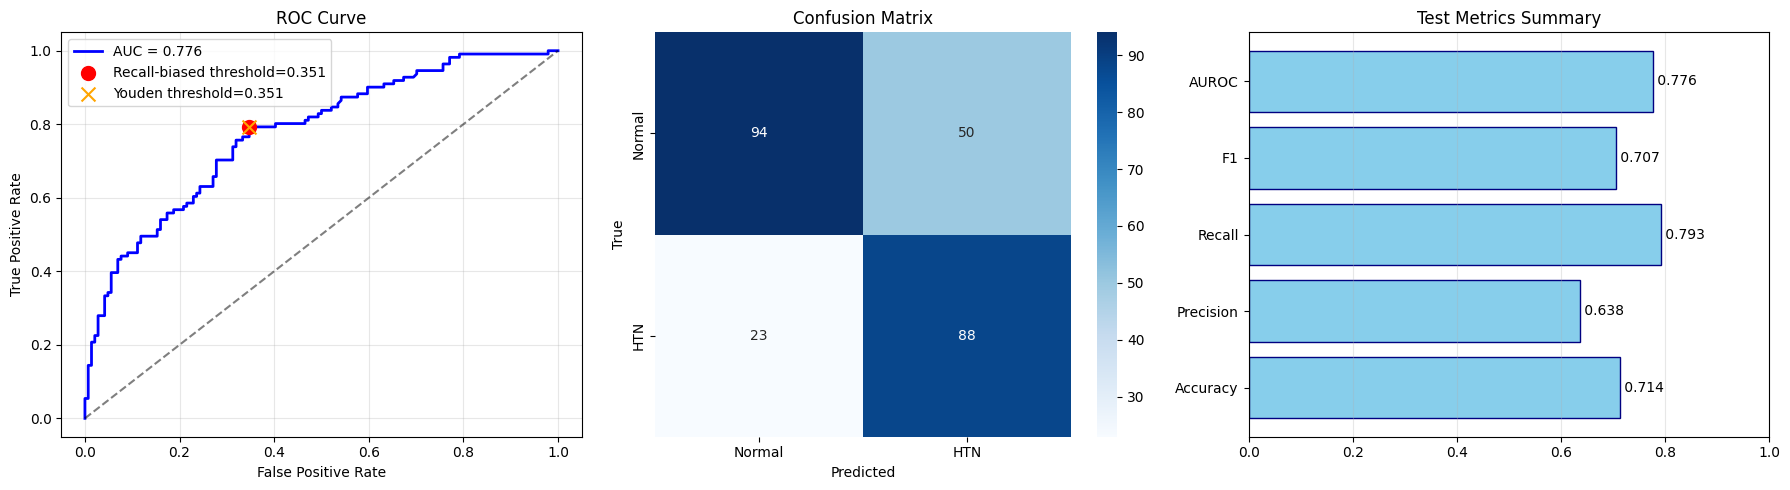


✅ ALL DONE! Model trained on 3 datasets successfully.


In [23]:
# ==================== CELL 16: Test Evaluation ====================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score

# Load best model
if best_state:
    model.load_state_dict(best_state["model"])
    print("✓ Loaded best model")

model.eval()
all_logits = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images).cpu().view(-1)
        all_logits.append(logits)
        all_labels.append(labels)

all_logits = torch.cat(all_logits).numpy()
all_labels = torch.cat(all_labels).numpy()
probs = 1 / (1 + np.exp(-all_logits))

# Compute metrics
fpr, tpr, thresholds = roc_curve(all_labels, probs)
test_auroc = auc(fpr, tpr)

# IMPROVED: Find threshold that maximizes recall while maintaining reasonable F1
# AGGRESSIVE: Prioritize recall heavily (reduce false negatives)
from sklearn.metrics import recall_score, precision_score

best_score = -1
best_threshold = 0.4  # Start lower to favor recall
best_idx = 0

# Strategy: Find threshold that gives recall >= 0.65, then maximize F1
# If no threshold gives recall >= 0.65, use the one with highest recall
target_recall = 0.65
candidates = []

for i, threshold in enumerate(thresholds):
    preds_thresh = (probs >= threshold).astype(int)
    rec = recall_score(all_labels, preds_thresh)
    prec = precision_score(all_labels, preds_thresh, zero_division=0)
    f1 = f1_score(all_labels, preds_thresh)

    # If recall meets target, prioritize F1
    if rec >= target_recall:
        score = f1  # Among candidates meeting recall target, pick best F1
        candidates.append((score, threshold, i, rec, prec, f1))
    else:
        # If recall below target, use weighted metric heavily favoring recall
        score = (2.0 * rec + prec) / 3.0  # Recall is 2x more important

    if score > best_score:
        best_score = score
        best_threshold = threshold
        best_idx = i
        best_recall = rec
        best_precision = prec
        best_f1 = f1

# If we found candidates meeting recall target, use the one with best F1
if candidates:
    candidates.sort(key=lambda x: x[0], reverse=True)
    best_score, best_threshold, best_idx, best_recall, best_precision, best_f1 = candidates[0]
    print(f"✓ Found threshold meeting recall target (≥{target_recall:.2f})")

# Also compute Youden's index and standard F1 for comparison
youden_idx = np.argmax(tpr - fpr)
youden_threshold = thresholds[youden_idx]

# Standard F1 optimization for comparison
best_f1_standard = 0
best_threshold_f1 = 0.5
for i, threshold in enumerate(thresholds):
    preds_thresh = (probs >= threshold).astype(int)
    f1 = f1_score(all_labels, preds_thresh)
    if f1 > best_f1_standard:
        best_f1_standard = f1
        best_threshold_f1 = threshold

preds = (probs >= best_threshold).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score
test_acc = accuracy_score(all_labels, preds)
test_prec = precision_score(all_labels, preds, zero_division=0)
test_rec = recall_score(all_labels, preds)
test_f1 = f1_score(all_labels, preds)

print("\n" + "="*70)
print("FINAL TEST RESULTS (3 Datasets Combined)")
print("="*70)
print(f"Test AUROC:     {test_auroc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall:    {test_rec:.4f}")  # Should be improved now!
print(f"Test F1 Score:  {test_f1:.4f}")
print(f"Best threshold (Recall-biased F1): {best_threshold:.4f}")
print(f"  → Recall: {best_recall:.4f}, Precision: {best_precision:.4f}, F1: {best_f1:.4f}")
print(f"Standard F1 threshold: {best_threshold_f1:.4f}")
print(f"Youden threshold: {youden_threshold:.4f}")
print("="*70)

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ROC Curve
axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {test_auroc:.3f}')
axes[0].plot([0,1], [0,1], 'k--', alpha=0.5)
axes[0].scatter(fpr[best_idx], tpr[best_idx], c='red', s=100, zorder=5, label=f'Recall-biased threshold={best_threshold:.3f}')
axes[0].scatter(fpr[youden_idx], tpr[youden_idx], c='orange', s=100, zorder=5, marker='x', label=f'Youden threshold={youden_threshold:.3f}')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confusion Matrix
cm = confusion_matrix(all_labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Normal', 'HTN'],
            yticklabels=['Normal', 'HTN'])
axes[1].set_title('Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# Metrics bar chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUROC']
metrics_values = [test_acc, test_prec, test_rec, test_f1, test_auroc]
axes[2].barh(metrics_names, metrics_values, color='skyblue', edgecolor='navy')
for i, v in enumerate(metrics_values):
    axes[2].text(v, i, f' {v:.3f}', va='center')
axes[2].set_xlim([0, 1])
axes[2].set_title('Test Metrics Summary')
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('/content/test_results_3datasets.png', dpi=150)
print("\n✓ Saved test results plot")
plt.show()

print("\n✅ ALL DONE! Model trained on 3 datasets successfully.")

In [21]:
import shutil
import os

source_path = '/content/best_retfound_htn_3datasets.pt'

# Define the destination folder in Google Drive
drive_folder = '/content/drive/MyDrive/trained_models'

# Create the folder if it doesn't exist
os.makedirs(drive_folder, exist_ok=True)

destination_path = os.path.join(drive_folder, 'best_retfound_htn_3datasets.pt')

# Copy the file
shutil.copy(source_path, destination_path)

print(f"✓ Model saved to Google Drive at: {destination_path}")

✓ Model saved to Google Drive at: /content/drive/MyDrive/trained_models/best_retfound_htn_3datasets.pt
